In [1]:
import cse_pandas as cse_pd

## Introduction

This notebook demonstrates the capabilities of **cse_pandas** class. 

The class relies on the **cse_s3_client** which is an implementation of client side encryption using boto3. It uses modified code from the [aiboto3 library](https://github.com/terrycain/aioboto3). The aiboto3 library supports CSE but it is tightly coupled with asynchronous nature of the library, which is not easy or practical to use from environments such as Jypyter notebooks. The re-implementation simplifies the code and makes it easier to use alongside boto3. 

In addition,cse_pandas,  provides methods for reading panda dataframes form  both plaintext and client-side-encrypted (CSE) s3 objects abstracting the s3 semantics. 

It also allows writting dataframes to S3 as  either plain text or CSE. It supports delimited(csv,tsb,etc) and parquet files and it can be used to convert from one format to another. 

The class emulates the pandas **read_csv**/**write_csv** and **read_parquet**/**write_parquet** methods with the same signature but *with the addition of the bucket and object key parameters as well as an optional cms_id** which when specified will store the dataframe with cse-kms;when reading the libraries will automatically use the cmk id found in the object's metadata. However, this can be overriden by supplying the cmk_id parameter which will be used instead. This can be useful in manual key rotation scenarios.

The class provides helper methods to query the encryption status and return metadata of an s3 object as dataframe  and a built-in helper CSEPerformanceCounters object which allows to query and report performance data as dataframes.


This notebook demonstrates the above functionality with the  the direct marketing dataset used in the AWS Sagemaker Immersion Day downloaded from the sample data s3 bucket.

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 201

In [2]:
bucket = "sagemaker-studio-t9sc0jup0m8"
filename = "bank-additional/bank-additional-full.csv"

df=cse_pd.read_csv_df(bucket,filename)
df.head()

2022-02-13 17:23:09,555: INFO: Found credentials in shared credentials file: ~/.aws/credentials
2022-02-13 17:23:09,595: INFO: Downloading object and its metadata from S3
2022-02-13 17:23:10,991: INFO: bank-additional/bank-additional-full.csv was read in 0.033100613 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
metadata = cse_pd.file_metadata(bucket,filename)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-13 17:23:11,200: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-13 17:23:11,970: INFO: Metadata for bank-additional/bank-additional-full.csv was read in 0.021298633999999872 seconds


Is file encrypted? False
S3 Metadata


,Key,Value


Create an unencrypted copy by not specifying a CMK

In [5]:
cse_cmk_us = "arn:aws:kms:us-east-1:299691842772:alias/cse-us"
copy_object_key=cse_pd.write_csv_df(df, "sagemaker-studio-t9sc0jup0m8","bank-additional/bank-additional-full-copy.csv", index=False)
print(copy_object_key)

2022-02-13 17:23:12,295: INFO: Writing object and its metadata to S3 (no CSE)
2022-02-13 17:23:13,938: INFO: bank-additional/bank-additional-full-copy.csv was writen in 0.0656881359999999 seconds


bank-additional/bank-additional-full-copy.csv


Ensure we can read the unencrypted copy and its identical to the original

In [6]:
copy_df=cse_pd.read_csv_df(bucket,copy_object_key)
print("Are the two datasets identical?",df.equals(copy_df))
copy_df.head()

2022-02-13 17:23:14,075: INFO: Downloading object and its metadata from S3
2022-02-13 17:23:15,531: INFO: bank-additional/bank-additional-full-copy.csv was read in 0.035014667 seconds


Are the two datasets identical? True


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Create an encrypted copy with CSE-KMS using a KMS CMK i.e cmk_id=cse_cmk_us

In [7]:
cse_cmk_us = "arn:aws:kms:us-east-1:299691842772:alias/cse-us"
object_key=cse_pd.write_csv_df(df, "sagemaker-studio-t9sc0jup0m8","bank-additional/bank-additional-full-enc.csv", cmk_id=cse_cmk_us, index=False)
print(object_key)

2022-02-13 17:23:15,935: INFO: Writing object and its metadata to S3 (CSE using CMK arn:aws:kms:us-east-1:299691842772:alias/cse-us)
2022-02-13 17:23:17,933: INFO: bank-additional/bank-additional-full-enc.csv was writen in 0.13712152400000033 seconds


bank-additional/bank-additional-full-enc.csv


Confirm encryption from metadata

In [8]:
metadata = cse_pd.file_metadata(bucket,object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-13 17:23:17,973: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-13 17:23:18,385: INFO: Metadata for bank-additional/bank-additional-full-enc.csv was read in 0.033874607 seconds


Is file encrypted? True
S3 Metadata


,Key,Value
0,x-amz-tag-len,128
1,x-amz-unencrypted-content-length,4974759
2,x-amz-wrap-alg,kms
3,x-amz-matdesc,"{""kms_cmk_id"": ""arn:aws:kms:us-east-1:29969184..."
4,x-amz-key-v2,AQIDAHgTkqfXAKlb7mEny/rGzSpLgyK/Jm4NSBJpdtgwnQ...
5,x-amz-cek-alg,AES/GCM/NoPadding
6,x-amz-iv,aiRajI9+vIEv+/Kg


Create a second data frame from the encrypted object

In [9]:
encrypted_df = cse_pd.read_csv_df(bucket,object_key)
encrypted_df.head()

2022-02-13 17:23:18,437: INFO: Downloading object and its metadata from S3
2022-02-13 17:23:20,157: INFO: bank-additional/bank-additional-full-enc.csv was read in 0.11911988800000017 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
#Are the two data frames the same?
df.equals(encrypted_df)

True

In [11]:
#Convert to parquet and save unencrypted
parquet_object_key=cse_pd.write_parquet_df(df, "sagemaker-studio-t9sc0jup0m8","bank-additional/bank-additional-full.parquet", index=False)
print(parquet_object_key)

2022-02-13 17:23:20,433: INFO: Writing object and its metadata to S3 (no CSE)
2022-02-13 17:23:21,339: INFO: bank-additional/bank-additional-full.parquet was writen in 0.028689707999999925 seconds


bank-additional/bank-additional-full.parquet


In [12]:
metadata = cse_pd.file_metadata(bucket,parquet_object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-13 17:23:21,375: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-13 17:23:21,799: INFO: Metadata for bank-additional/bank-additional-full.parquet was read in 0.028470525999999552 seconds


Is file encrypted? False
S3 Metadata


,Key,Value


In [13]:
parquet_df = cse_pd.read_parquet_df(bucket,parquet_object_key)
parquet_df.head()

2022-02-13 17:23:21,852: INFO: Downloading object and its metadata from S3
2022-02-13 17:23:22,580: INFO: bank-additional/bank-additional-full.parquet was read in 0.0347085620000005 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [14]:
#Are the two data frames the same?
df.equals(parquet_df)

True

In [15]:
# save parquet encrypted
encrypted_parquet_object_key=cse_pd.write_parquet_df(df, "sagemaker-studio-t9sc0jup0m8","bank-additional/bank-additional-full-enc.parquet", cmk_id= cse_cmk_us , index=False)
print(encrypted_parquet_object_key)

2022-02-13 17:23:22,849: INFO: Writing object and its metadata to S3 (CSE using CMK arn:aws:kms:us-east-1:299691842772:alias/cse-us)
2022-02-13 17:23:24,262: INFO: bank-additional/bank-additional-full-enc.parquet was writen in 0.060820587999999454 seconds


bank-additional/bank-additional-full-enc.parquet


In [16]:
metadata = cse_pd.file_metadata(bucket,encrypted_parquet_object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-13 17:23:24,304: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-13 17:23:24,771: INFO: Metadata for bank-additional/bank-additional-full-enc.parquet was read in 0.04233375100000014 seconds


Is file encrypted? True
S3 Metadata


,Key,Value
0,x-amz-tag-len,128
1,x-amz-unencrypted-content-length,236449
2,x-amz-wrap-alg,kms
3,x-amz-matdesc,"{""kms_cmk_id"": ""arn:aws:kms:us-east-1:29969184..."
4,x-amz-key-v2,AQIDAHgTkqfXAKlb7mEny/rGzSpLgyK/Jm4NSBJpdtgwnQ...
5,x-amz-cek-alg,AES/GCM/NoPadding
6,x-amz-iv,3F/1uJMPKyBasetL


In [17]:
# read the encrypted parquet file
encrypted_parquet_df = cse_pd.read_parquet_df(bucket, encrypted_parquet_object_key)
encrypted_parquet_df.head()

2022-02-13 17:23:24,826: INFO: Downloading object and its metadata from S3
2022-02-13 17:23:25,956: INFO: bank-additional/bank-additional-full-enc.parquet was read in 0.06041283899999961 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
counters_df = cse_pd.get_performance_counters()
counters_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
0,Sun Feb 13 17:23:10 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.csv,csv,read,NO CSE,0.033101
1,Sun Feb 13 17:23:11 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.csv,csv,head,NO CSE,0.021299
2,Sun Feb 13 17:23:13 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.065688
3,Sun Feb 13 17:23:14 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.035015
4,Sun Feb 13 17:23:17 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,write,CSE,0.137122
5,Sun Feb 13 17:23:18 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,head,NO CSE,0.033875
6,Sun Feb 13 17:23:20 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,read,CSE,0.119120
7,Sun Feb 13 17:23:21 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.028690
8,Sun Feb 13 17:23:21 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,head,NO CSE,0.028471
9,Sun Feb 13 17:23:22 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.034709


In [32]:
readwrite_df=counters_df[counters_df['operation']!='head']
readwrite_df = readwrite_df.iloc[1:, :]

In [33]:
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
2,Sun Feb 13 17:23:13 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.065688
3,Sun Feb 13 17:23:14 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.035015
4,Sun Feb 13 17:23:17 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,write,CSE,0.137122
6,Sun Feb 13 17:23:20 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,read,CSE,0.119120
7,Sun Feb 13 17:23:21 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.028690
9,Sun Feb 13 17:23:22 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.034709
10,Sun Feb 13 17:23:24 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.parquet,parquet,write,CSE,0.060821
12,Sun Feb 13 17:23:25 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.parquet,parquet,read,CSE,0.060413


In [34]:
readwrite_df= readwrite_df[readwrite_df['file_type']=='csv']
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
2,Sun Feb 13 17:23:13 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.065688
3,Sun Feb 13 17:23:14 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.035015
4,Sun Feb 13 17:23:17 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,write,CSE,0.137122
6,Sun Feb 13 17:23:20 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.csv,csv,read,CSE,0.119120


In [35]:
import utils
summary_df = utils.counters_summary_df(readwrite_df, 'operation', 'cse', 'duration')
summary_df

,CSE,NO CSE
operation,,
write,0.137122,0.065688
read,0.119120,0.035015


<AxesSubplot:title={'center':'read/write times for CSV objects'}, xlabel='operation'>

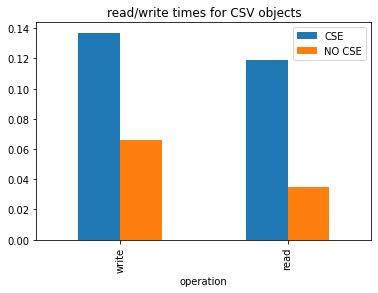

In [36]:
summary_df.plot(kind="bar",title='read/write times for CSV objects')

In [37]:
readwrite_df= counters_df[counters_df['operation']!='head']
readwrite_df= readwrite_df[readwrite_df['file_type']=='parquet']
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
7,Sun Feb 13 17:23:21 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.028690
9,Sun Feb 13 17:23:22 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.034709
10,Sun Feb 13 17:23:24 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.parquet,parquet,write,CSE,0.060821
12,Sun Feb 13 17:23:25 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-enc.parquet,parquet,read,CSE,0.060413


In [38]:
summary_df = utils.counters_summary_df(readwrite_df, 'operation', 'cse', 'duration')
summary_df

,CSE,NO CSE
operation,,
write,0.060821,0.028690
read,0.060413,0.034709


<AxesSubplot:title={'center':'read/write times for parquet objects'}, xlabel='operation'>

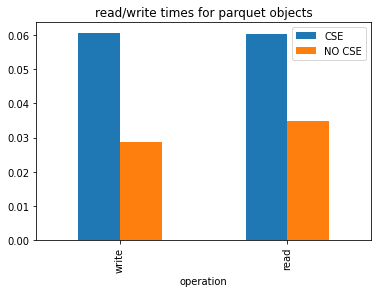

In [39]:
summary_df.plot(kind="bar",title='read/write times for parquet objects')